## Amruta Mahendra Parulekar  20D070009
## Keshav Singhal 20D070047
## Sameep Chattopadhyay 20d070067

In [ ]:
%matplotlib inline

In [ ]:
!pip install pydub torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchaudio
import sys

import matplotlib.pyplot as plt
import IPython.display as ipd

from tqdm import tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.7.0+cu101 (from versions: 1.7.1, 1.7.1+cpu, 1.7.1+cu101, 1.7.1+cu110, 1.7.1+cu92, 1.7.1+rocm3.7, 1.7.1+rocm3.8, 1.8.0, 1.8.0+cpu, 1.8.0+cu101, 1.8.0+cu111, 1.8.0+rocm3.10, 1.8.0+rocm4.0.1, 1.8.1, 1.8.1+cpu, 1.8.1+cu101, 1.8.1+cu102, 1.8.1+cu111, 1.8.1+rocm3.10, 1.8.1+rocm4.0.1, 1.9.0, 1.9.0+cpu, 1.9.0+cu102, 1.9.0+cu111, 1.9.0+rocm4.0.1, 1.9.0+rocm4.1, 1.9.0+rocm4.2, 1.9.1, 1.9.1+cpu, 1.9.1+cu102, 1.9.1+cu111, 1.9.1+rocm4.0.1, 1.9.1+rocm4.1, 1.9.1+rocm4.2, 1.10.0, 1.10.0+cpu, 1.10.0+cu102, 1.10.0+cu111, 1.10.0+cu113, 1.10.0+rocm4.0.1, 1.10.0+rocm4.1, 1.10.0+rocm4.2, 1.10.1, 1.10.1+cpu, 1.10.1+cu102, 1.10.1+cu111, 1.10.1+cu113, 1.10.1+rocm4.0.1, 1.10.1+rocm4.1, 1.10.1+rocm4.2, 1.10.2, 1.10.2+cpu, 1.10.2+cu102, 1.10.2+cu111, 1.10.2+cu113, 1.10.2+rocm4.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
from torchaudio.datasets import SPEECHCOMMANDS
import os


class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset: str = None):
        super().__init__("./", download=True)

        def load_list(filename):
            filepath = os.path.join(self._path, filename)
            with open(filepath) as fileobj:
                return [os.path.normpath(os.path.join(self._path, line.strip())) for line in fileobj]

        if subset == "validation":
            self._walker = load_list("validation_list.txt")
        elif subset == "testing":
            self._walker = load_list("testing_list.txt")
        elif subset == "training":
            excludes = load_list("validation_list.txt") + load_list("testing_list.txt")
            excludes = set(excludes)
            self._walker = [w for w in self._walker if w[2:] not in excludes] #Edited line to get correct training set, Keshav


# Create training and testing split of the data. We do not use validation in this tutorial.
train_set_init = SubsetSC("training")
test_set_init = SubsetSC("testing")



  0%|          | 0.00/2.26G [00:00<?, ?B/s]

In [ ]:
len(train_set_init)

105829

In [ ]:
import urllib.request as req
data_test = req.urlopen(r"https://www.cse.iitb.ac.in/~pjyothi/cs753/test_list.txt")
data_train = req.urlopen(r"https://www.cse.iitb.ac.in/~pjyothi/cs753/train_list.txt")
n_test=[]
n_train=[]
for num in data_test:
  n_test.append(int(num))
for num in data_train:
  n_train.append(int(num))

In [ ]:
train_set=list([train_set_init[n] for n in n_train])
test_set=list([test_set_init[n] for n in n_test])

In [ ]:
waveform, sample_rate, label, speaker_id, utterance_number = train_set[-1]
print(sample_rate)
print(label)
print(utterance_number)
print(speaker_id)

16000
tree
0
1afd49bf


In [ ]:
len(train_set)

12000

In [ ]:
waveform.t().numpy().shape

(15019, 1)

Shape of waveform: torch.Size([1, 15019])
Sample rate of waveform: 16000


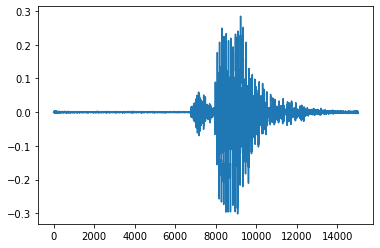

In [ ]:
print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

plt.plot(waveform.t().numpy());

In [ ]:
labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
len(labels)

29

In [ ]:
test_set_temp=[]
for i in range(len(test_set)):
  if test_set[i][2] in labels:
    test_set_temp.append(test_set[i])
test_set=list(test_set_temp)

In [ ]:
id = sorted(list(set(datapoint[4] for datapoint in train_set)))
len(id)

19

In [ ]:
waveform_first, *_ = train_set[4504]
ipd.Audio(waveform_first.numpy(), rate=sample_rate)

In [ ]:
new_sample_rate = 8000
transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
transformed = transform(waveform)

ipd.Audio(transformed.numpy(), rate=new_sample_rate)

In [ ]:
def label_to_index(word):
    # Return the position of the word in labels
    return torch.tensor(labels.index(word))


def index_to_label(index):
    # Return the word corresponding to the index in labels
    # This is the inverse of label_to_index
    return labels[index]


word_start = "bed"
index = label_to_index(word_start)
word_recovered = index_to_label(index)

print(word_start, "-->", index, "-->", word_recovered)

bed --> tensor(1) --> bed


In [ ]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):

    # A data tuple has the form:
    # waveform, sample_rate, label, speaker_id, utterance_number

    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, _, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets


batch_size = 256

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

In [ ]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)


model = M5(n_input=transformed.shape[0], n_output=len(labels))
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=29, bias=True)
)
Numbe

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)  # reduce the learning after 20 epochs by a factor of 10

In [ ]:
# basic random seed
import os
import random
import numpy as np
DEFAULT_RANDOM_SEED = 2021
def seedBasic(seed=DEFAULT_RANDOM_SEED):
 random.seed(seed)
 os.environ['PYTHONHASHSEED'] = str(seed)
 np.random.seed(seed)
# tensorflow random seed
 import tensorflow as tf
def seedTF(seed=DEFAULT_RANDOM_SEED):
 tf.random.set_seed(seed)
# torch random seed
 import torch
def seedTorch(seed=DEFAULT_RANDOM_SEED):
 torch.manual_seed(seed)
 torch.cuda.manual_seed(seed)
 torch.backends.cudnn.deterministic = True
 torch.backends.cudnn.benchmark = False
# basic + tensorflow + torch
def seedEverything(seed=DEFAULT_RANDOM_SEED):
 seedBasic(seed)
 seedTF(seed)
 seedTorch(seed)
 seedEverything(1004)

In [ ]:
def train(model, epoch, log_interval):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        # negative log-likelihood for a tensor of size (batch x 1 x n_output)
        loss = F.nll_loss(output.squeeze(), target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print training stats
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")

        # update progress bar
        pbar.update(pbar_update)
        # record loss
        losses.append(loss.item())

In [ ]:
def number_of_correct(pred, target):
    # count number of correct predictions
    return pred.squeeze().eq(target).sum().item()


def get_likely_index(tensor):
    # find most likely label index for each element in the batch
    return tensor.argmax(dim=-1)


def test(model, epoch):
    model.eval()
    correct = 0
    for data, target in test_loader:

        data = data.to(device)
        target = target.to(device)

        # apply transform and model on whole batch directly on device
        data = transform(data)
        output = model(data)

        pred = get_likely_index(output)
        correct += number_of_correct(pred, target)

        # update progress bar
        pbar.update(pbar_update)

    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{len(test_loader.dataset)} ({100. * correct / len(test_loader.dataset):.2f}%)\n{100. * correct / len(test_loader.dataset):.2f}")

In [ ]:
log_interval = 20
n_epoch = 20

pbar_update = 1 / (len(train_loader) + len(test_loader))
losses = []

# The transform needs to live on the same device as the model and the data.
transform = transform.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval)
        test(model, epoch)
        scheduler.step()

  0%|          | 0.05/20 [00:09<47:10, 141.90s/it]                  

Train Epoch: 1 [0/12000 (0%)]	Loss: 3.504080


  2%|▏         | 0.41666666666666663/20 [00:09<01:44,  5.36s/it]

Train Epoch: 1 [5120/12000 (43%)]	Loss: 2.893085


  4%|▍         | 0.8000000000000008/20 [00:10<00:39,  2.07s/it]

Train Epoch: 1 [10240/12000 (85%)]	Loss: 2.391556


  5%|▌         | 1.0666666666666678/20 [00:10<00:29,  1.55s/it]


Test Epoch: 1	Accuracy: 993/3272 (30.35%)
30.35
Train Epoch: 2 [0/12000 (0%)]	Loss: 2.230829


  7%|▋         | 1.4333333333333331/20 [00:11<00:25,  1.37s/it]

Train Epoch: 2 [5120/12000 (43%)]	Loss: 1.850416


  9%|▉         | 1.7666666666666653/20 [00:11<00:23,  1.31s/it]

Train Epoch: 2 [10240/12000 (85%)]	Loss: 1.781303


 10%|█         | 2.083333333333331/20 [00:11<00:21,  1.19s/it] 


Test Epoch: 2	Accuracy: 1404/3272 (42.91%)
42.91
Train Epoch: 3 [0/12000 (0%)]	Loss: 1.518494


 12%|█▏        | 2.449999999999996/20 [00:12<00:22,  1.25s/it]

Train Epoch: 3 [5120/12000 (43%)]	Loss: 1.438037


 14%|█▍        | 2.7833333333333283/20 [00:12<00:21,  1.27s/it]

Train Epoch: 3 [10240/12000 (85%)]	Loss: 1.484767


 16%|█▌        | 3.1166666666666605/20 [00:13<00:20,  1.22s/it]


Test Epoch: 3	Accuracy: 1634/3272 (49.94%)
49.94
Train Epoch: 4 [0/12000 (0%)]	Loss: 1.268650


 17%|█▋        | 3.483333333333326/20 [00:13<00:19,  1.18s/it]

Train Epoch: 4 [5120/12000 (43%)]	Loss: 1.241381


 19%|█▉        | 3.7833333333333248/20 [00:13<00:18,  1.12s/it]

Train Epoch: 4 [10240/12000 (85%)]	Loss: 1.160200


 21%|██        | 4.149999999999991/20 [00:14<00:16,  1.03s/it]


Test Epoch: 4	Accuracy: 1603/3272 (48.99%)
48.99
Train Epoch: 5 [0/12000 (0%)]	Loss: 1.198005


 22%|██▏       | 4.4499999999999895/20 [00:14<00:16,  1.08s/it]

Train Epoch: 5 [5120/12000 (43%)]	Loss: 1.197548


 24%|██▍       | 4.866666666666655/20 [00:15<00:15,  1.02s/it] 

Train Epoch: 5 [10240/12000 (85%)]	Loss: 1.000604


 26%|██▌       | 5.13333333333332/20 [00:15<00:14,  1.00it/s] 


Test Epoch: 5	Accuracy: 2117/3272 (64.70%)
64.70
Train Epoch: 6 [0/12000 (0%)]	Loss: 1.112771


 27%|██▋       | 5.449999999999986/20 [00:15<00:15,  1.04s/it]

Train Epoch: 6 [5120/12000 (43%)]	Loss: 0.991381


 29%|██▉       | 5.866666666666651/20 [00:16<00:14,  1.02s/it]

Train Epoch: 6 [10240/12000 (85%)]	Loss: 0.941420


 31%|███       | 6.133333333333317/20 [00:16<00:14,  1.02s/it]


Test Epoch: 6	Accuracy: 2120/3272 (64.79%)
64.79
Train Epoch: 7 [0/12000 (0%)]	Loss: 0.998402


 33%|███▎      | 6.5333333333333155/20 [00:16<00:14,  1.05s/it]

Train Epoch: 7 [5120/12000 (43%)]	Loss: 0.946425


 34%|███▍      | 6.849999999999981/20 [00:17<00:13,  1.02s/it]

Train Epoch: 7 [10240/12000 (85%)]	Loss: 0.895353


 36%|███▌      | 7.116666666666647/20 [00:17<00:12,  1.01it/s] 


Test Epoch: 7	Accuracy: 2104/3272 (64.30%)
64.30
Train Epoch: 8 [0/12000 (0%)]	Loss: 0.747270


 37%|███▋      | 7.449999999999979/20 [00:17<00:12,  1.03s/it]

Train Epoch: 8 [5120/12000 (43%)]	Loss: 0.888001


 39%|███▉      | 7.866666666666644/20 [00:18<00:12,  1.01s/it]

Train Epoch: 8 [10240/12000 (85%)]	Loss: 1.002346


 41%|████      | 8.133333333333317/20 [00:18<00:11,  1.01it/s]


Test Epoch: 8	Accuracy: 2185/3272 (66.78%)
66.78
Train Epoch: 9 [0/12000 (0%)]	Loss: 0.752854


 42%|████▏     | 8.45/20 [00:18<00:12,  1.04s/it]             

Train Epoch: 9 [5120/12000 (43%)]	Loss: 0.837931


 44%|████▍     | 8.866666666666687/20 [00:19<00:11,  1.01s/it]

Train Epoch: 9 [10240/12000 (85%)]	Loss: 0.739923


 46%|████▌     | 9.1166666666667/20 [00:19<00:10,  1.00s/it]  


Test Epoch: 9	Accuracy: 2258/3272 (69.01%)
69.01
Train Epoch: 10 [0/12000 (0%)]	Loss: 0.634203


 48%|████▊     | 9.533333333333387/20 [00:19<00:10,  1.04s/it]

Train Epoch: 10 [5120/12000 (43%)]	Loss: 0.689940


 49%|████▉     | 9.850000000000069/20 [00:20<00:10,  1.02s/it]

Train Epoch: 10 [10240/12000 (85%)]	Loss: 0.668695


 51%|█████     | 10.100000000000081/20 [00:20<00:09,  1.02it/s]


Test Epoch: 10	Accuracy: 2159/3272 (65.98%)
65.98
Train Epoch: 11 [0/12000 (0%)]	Loss: 0.695090


 53%|█████▎    | 10.516666666666769/20 [00:20<00:09,  1.04s/it]

Train Epoch: 11 [5120/12000 (43%)]	Loss: 0.572163


 54%|█████▍    | 10.816666666666784/20 [00:21<00:09,  1.05s/it]

Train Epoch: 11 [10240/12000 (85%)]	Loss: 0.631702


 55%|█████▌    | 11.066666666666796/20 [00:21<00:08,  1.03it/s]


Test Epoch: 11	Accuracy: 2346/3272 (71.70%)
71.70
Train Epoch: 12 [0/12000 (0%)]	Loss: 0.586558


 58%|█████▊    | 11.500000000000151/20 [00:21<00:08,  1.03s/it]

Train Epoch: 12 [5120/12000 (43%)]	Loss: 0.656751


 59%|█████▉    | 11.800000000000166/20 [00:22<00:08,  1.05s/it]

Train Epoch: 12 [10240/12000 (85%)]	Loss: 0.678945


 60%|██████    | 12.066666666666846/20 [00:22<00:07,  1.06it/s]


Test Epoch: 12	Accuracy: 2274/3272 (69.50%)
69.50
Train Epoch: 13 [0/12000 (0%)]	Loss: 0.575079


 63%|██████▎   | 12.5000000000002/20 [00:22<00:07,  1.04s/it]  

Train Epoch: 13 [5120/12000 (43%)]	Loss: 0.523681


 64%|██████▍   | 12.800000000000216/20 [00:23<00:07,  1.07s/it]

Train Epoch: 13 [10240/12000 (85%)]	Loss: 0.702104


 65%|██████▌   | 13.050000000000228/20 [00:23<00:06,  1.04it/s]


Test Epoch: 13	Accuracy: 2179/3272 (66.60%)
66.60
Train Epoch: 14 [0/12000 (0%)]	Loss: 0.506439


 67%|██████▋   | 13.466666666666915/20 [00:23<00:08,  1.24s/it]

Train Epoch: 14 [5120/12000 (43%)]	Loss: 0.637614


 69%|██████▉   | 13.800000000000265/20 [00:24<00:07,  1.27s/it]

Train Epoch: 14 [10240/12000 (85%)]	Loss: 0.504687


 71%|███████   | 14.133333333333615/20 [00:24<00:06,  1.16s/it]


Test Epoch: 14	Accuracy: 2409/3272 (73.62%)
73.62
Train Epoch: 15 [0/12000 (0%)]	Loss: 0.414606


 72%|███████▏  | 14.43333333333363/20 [00:25<00:06,  1.21s/it] 

Train Epoch: 15 [5120/12000 (43%)]	Loss: 0.439215


 74%|███████▍  | 14.76666666666698/20 [00:25<00:06,  1.29s/it] 

Train Epoch: 15 [10240/12000 (85%)]	Loss: 0.486831


 76%|███████▌  | 15.10000000000033/20 [00:25<00:05,  1.09s/it] 


Test Epoch: 15	Accuracy: 2244/3272 (68.58%)
68.58
Train Epoch: 16 [0/12000 (0%)]	Loss: 0.446907


 78%|███████▊  | 15.50000000000035/20 [00:26<00:04,  1.08s/it] 

Train Epoch: 16 [5120/12000 (43%)]	Loss: 0.511788


 79%|███████▉  | 15.800000000000365/20 [00:26<00:04,  1.09s/it]

Train Epoch: 16 [10240/12000 (85%)]	Loss: 0.376536


 81%|████████  | 16.16666666666703/20 [00:26<00:03,  1.01s/it]


Test Epoch: 16	Accuracy: 2193/3272 (67.02%)
67.02
Train Epoch: 17 [0/12000 (0%)]	Loss: 0.477894


 82%|████████▏ | 16.466666666667013/20 [00:27<00:03,  1.05s/it]

Train Epoch: 17 [5120/12000 (43%)]	Loss: 0.374224


 84%|████████▍ | 16.883333333333656/20 [00:27<00:03,  1.00it/s]

Train Epoch: 17 [10240/12000 (85%)]	Loss: 0.456050


 86%|████████▌ | 17.133333333333642/20 [00:27<00:02,  1.02s/it]


Test Epoch: 17	Accuracy: 2304/3272 (70.42%)
70.42
Train Epoch: 18 [0/12000 (0%)]	Loss: 0.482869


 87%|████████▋ | 17.45000000000029/20 [00:28<00:02,  1.06s/it] 

Train Epoch: 18 [5120/12000 (43%)]	Loss: 0.290801


 89%|████████▉ | 17.866666666666934/20 [00:28<00:02,  1.03s/it]

Train Epoch: 18 [10240/12000 (85%)]	Loss: 0.382095


 91%|█████████ | 18.133333333333585/20 [00:29<00:01,  1.01s/it]


Test Epoch: 18	Accuracy: 2332/3272 (71.27%)
71.27
Train Epoch: 19 [0/12000 (0%)]	Loss: 0.387775


 93%|█████████▎| 18.533333333333562/20 [00:29<00:01,  1.05s/it]

Train Epoch: 19 [5120/12000 (43%)]	Loss: 0.383562


 94%|█████████▍| 18.85000000000021/20 [00:29<00:01,  1.04s/it]

Train Epoch: 19 [10240/12000 (85%)]	Loss: 0.473701


 96%|█████████▌| 19.116666666666863/20 [00:30<00:00,  1.01it/s]


Test Epoch: 19	Accuracy: 2427/3272 (74.17%)
74.17
Train Epoch: 20 [0/12000 (0%)]	Loss: 0.368118


 98%|█████████▊| 19.533333333333506/20 [00:30<00:00,  1.03s/it]

Train Epoch: 20 [5120/12000 (43%)]	Loss: 0.371845


 99%|█████████▉| 19.850000000000154/20 [00:30<00:00,  1.02s/it]

Train Epoch: 20 [10240/12000 (85%)]	Loss: 0.332527


/usr/local/lib/python3.9/dist-packages/tqdm/std.py:524: TqdmWarning: clamping frac to range [0, 1]
  full_bar = Bar(frac,
100%|██████████| 20.000000000000146/20 [00:30<00:00,  1.55s/it]


Test Epoch: 20	Accuracy: 2338/3272 (71.45%)
71.45
